# MIKH Model: Steady-State Flow Curves

> **Handbook:** See [MIKH Reference](../../docs/source/models/ikh/mikh.rst) for complete governing equations, parameter estimation methods, and industrial applications of MIKH to steady-state flow curves.

## What is the Isotropic Kinematic Hardening (IKH) Framework?

The **Isotropic-Kinematic Hardening (IKH)** family provides comprehensive constitutive equations for **thixotropic elasto-viscoplastic (TEvp)** materials — complex fluids exhibiting yield stress, structure-dependent yielding, time-dependent rebuilding/breakdown (thixotropy), and directional memory (kinematic hardening/Bauschinger effect).

**Physical Foundation:**
- **Elastoviscoplasticity**: Combines elastic response (below yield) with rate-dependent plasticity (above yield)
- **Yield stress**: Critical stress $\sigma_y$ separating elastic and plastic regimes
- **Thixotropy**: Microstructural state (bonds, aggregates, networks) evolves with flow history
- **Kinematic hardening**: Backstress $\alpha$ captures directional anisotropy (Armstrong-Frederick framework)

**Key Physics:**
- **Yield surface**: $|\sigma - \alpha| \leq \sigma_y(\lambda)$ (von Mises with backstress shift)
- **Structure parameter**: $\lambda \in [0, 1]$ tracks intact bonds/aggregates
- **Isotropic hardening**: Yield stress $\sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda$ grows with structure
- **Bauschinger effect**: Easier reverse flow after forward loading (via backstress $\alpha$)

**Two Models in RheoJAX:**
1. **MIKH** (Modified IKH — this notebook): Single structural timescale, nonlinear backstress evolution
2. **MLIKH** (Multi-Lambda IKH — NB07-12): N parallel modes for distributed thixotropic timescales

**Materials:** Waxy crude oils (pipeline restart), drilling fluids (borehole stability), greases (bearing startup), colloidal gels, structured emulsions, thixotropic cements (self-leveling), soft biological tissues

> **Further Reading:** See [IKH Handbook](../../docs/source/models/ikh/index.rst) for physical background, [MIKH Reference](../../docs/source/models/ikh/mikh.rst) for governing equations, industrial applications, and parameter estimation methods.

## Learning Objectives

1. Fit the **MIKH (Maxwell-Isotropic-Kinematic Hardening)** model to steady-state flow curve data
2. Understand the thixotropic yield stress: $\sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda$
3. Analyze the interplay between yield stress, kinematic hardening, and viscous contributions
4. Use NLSQ warm-start for efficient Bayesian inference with NUTS
5. Extract posterior distributions for 11 model parameters
6. Calibrate parameters for downstream synthetic data generation (NB03, NB05)

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)

**Estimated Time:** 2-3 minutes (fast demo), 10-15 minutes (full run)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    compute_fit_quality,
    get_mikh_param_names,
    load_ml_ikh_flow_curve,
    print_convergence_summary,
    print_parameter_comparison,
    save_ikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc

gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


70

## 2. Theory: MIKH Model

The **Maxwell-Isotropic-Kinematic Hardening (MIKH)** model describes thixotropic elasto-viscoplastic materials by combining:
1. Maxwell viscoelastic backbone
2. Armstrong-Frederick kinematic hardening (backstress evolution)
3. Isotropic hardening/softening via structural parameter $\lambda$ (thixotropy)

### Key Equations

**Steady-state flow curve** (at equilibrium structure):
$$
\sigma = \sigma_y(\lambda_{ss}) + \eta_{\infty}|\dot{\gamma}| + \text{plastic contribution}
$$

**Yield surface** (von Mises with backstress):
$$
|\sigma - \alpha| \leq \sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda
$$

**Structure evolution** (thixotropy):
$$
\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

**Backstress evolution** (Armstrong-Frederick):
$$
d\alpha = C \, d\gamma_p - \gamma_{dyn} |\alpha|^{m-1} \alpha |d\gamma_p|
$$

### Parameters (11 total)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **G** | $G$ | Shear modulus (Pa) | 10 - 10000 Pa |
| **eta** | $\eta$ | Maxwell viscosity (Pa·s) | 10 - 10^8 Pa·s |
| **C** | $C$ | Kinematic hardening modulus (Pa) | 10 - 500 Pa |
| **gamma_dyn** | $\gamma_{dyn}$ | Dynamic recovery strain | 0.01 - 10 |
| **m** | $m$ | AF recovery exponent | 0.5 - 2 |
| **sigma_y0** | $\sigma_{y0}$ | Minimal yield stress (Pa) | 1 - 100 Pa |
| **delta_sigma_y** | $\Delta\sigma_y$ | Structural yield contribution (Pa) | 0 - 100 Pa |
| **tau_thix** | $\tau_{thix}$ | Thixotropic rebuilding time (s) | 1 - 1000 s |
| **Gamma** | $\Gamma$ | Structure breakdown coefficient | 0.001 - 10 |
| **eta_inf** | $\eta_{\infty}$ | High-shear viscosity (Pa·s) | 0.01 - 10 Pa·s |
| **mu_p** | $\mu_p$ | Plastic viscosity (Pa·s) | 10^-6 - 1 Pa·s |

### Physical Interpretation

- **Yield stress** ($\sigma_y$): Below this stress, material behaves elastically
- **Thixotropy**: Structure ($\lambda$) rebuilds at rest, breaks down under flow
- **Kinematic hardening**: Backstress $\alpha$ shifts yield surface, causes Bauschinger effect
- **High-shear viscosity**: Newtonian contribution at high rates ($\eta_{\infty}|\dot{\gamma}|$)

## 3. Load Data

We load the steady-state flow curve data from Wei et al. 2018 (J. Rheol), which contains measurements from both ARG2 and ARES rheometers on a thixotropic yield-stress fluid.

In [3]:
# Load ARES rate sweep up data (recommended for flow curve fitting)
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


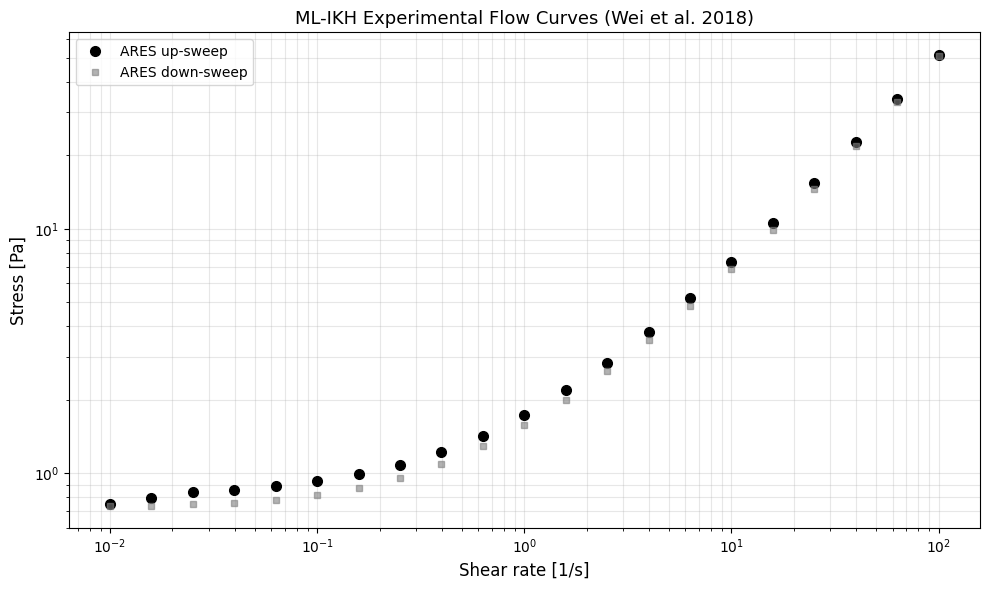

In [4]:
# Also load down-sweep for comparison (hysteresis check)
gamma_dot_down, stress_down = load_ml_ikh_flow_curve(instrument="ARES_down")

# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="ARES up-sweep")
ax.loglog(gamma_dot_down, stress_down, "s", color="gray", markersize=5, 
          alpha=0.6, label="ARES down-sweep")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Experimental Flow Curves (Wei et al. 2018)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Initial Fit

We fit the MIKH model to the ARES up-sweep data using NLSQ optimization.

In [5]:
# Create and fit MIKH model
model = MIKH()

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

# Get parameter names
param_names = get_mikh_param_names()

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.586707s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=19 | final_cost=4.1340 | elapsed=1.587s | final_gradient_norm=4.4580e-07


NLSQ fit time: 1.78 s

Fitted parameters:
  G               = 1000
  eta             = 100.2
  C               = 1.376e+04
  gamma_dyn       = 1.621
  m               = 1.369
  sigma_y0        = 1.328
  delta_sigma_y   = 0.01783
  tau_thix        = 4.119e+07
  Gamma           = 3351
  eta_inf         = 0.513
  mu_p            = 0.001


In [6]:
# Compute fit quality
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")

# Residual analysis
residuals = stress - stress_pred
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
print(f"\nResidual Analysis:")
print(f"  Mean residual:  {mean_residual:.4g} Pa (should be ~ 0)")
print(f"  Std residual:   {std_residual:.4g} Pa")
print(f"  Max residual:   {np.max(np.abs(residuals)):.4g} Pa")


Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa
  NRMSE: 1.2374%

Residual Analysis:
  Mean residual:  -3.658e-09 Pa (should be ~ 0)
  Std residual:   0.6275 Pa
  Max residual:   1.169 Pa


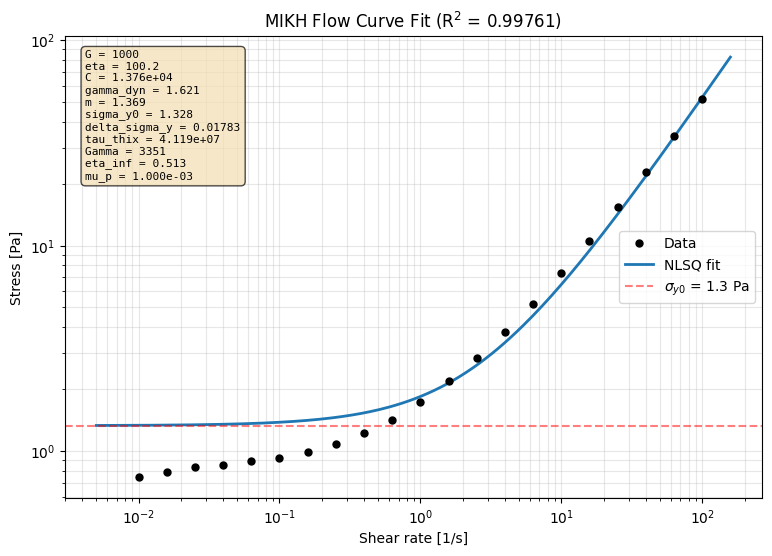

In [7]:
# Plot NLSQ fit with uncertainty band
fig, ax = plot_nlsq_fit(
    gamma_dot, stress, model, test_mode="flow_curve",
    param_names=param_names, log_scale=True,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title=f"MIKH Flow Curve Fit (R$^2$ = {metrics['R2']:.5f})",
)

# Add Herschel-Bulkley reference line
sigma_y0 = model.parameters.get_value("sigma_y0")
ax.axhline(sigma_y0, color="red", linestyle="--", alpha=0.5, label=f"$\\sigma_{{y0}}$ = {sigma_y0:.1f} Pa")
ax.legend(fontsize=10)

display(fig)
plt.close(fig)

### 4.2 Physical Analysis

Let's analyze the contributions from different physical mechanisms.

In [8]:
# Extract key physical parameters
sigma_y0 = model.parameters.get_value("sigma_y0")
delta_sigma_y = model.parameters.get_value("delta_sigma_y")
eta_inf = model.parameters.get_value("eta_inf")
tau_thix = model.parameters.get_value("tau_thix")
Gamma = model.parameters.get_value("Gamma")

print("Physical Analysis:")
print("=" * 50)
print(f"Minimal yield stress (destructured): {sigma_y0:.2f} Pa")
print(f"Maximum yield stress (structured):   {sigma_y0 + delta_sigma_y:.2f} Pa")
print(f"Yield stress range:                  {delta_sigma_y:.2f} Pa")
print(f"High-shear viscosity:                {eta_inf:.4g} Pa.s")
print(f"Thixotropic rebuilding time:         {tau_thix:.2g} s")
print(f"Breakdown coefficient:               {Gamma:.4g}")

Physical Analysis:
Minimal yield stress (destructured): 1.33 Pa
Maximum yield stress (structured):   1.35 Pa
Yield stress range:                  0.02 Pa
High-shear viscosity:                0.513 Pa.s
Thixotropic rebuilding time:         4.1e+07 s
Breakdown coefficient:               3351


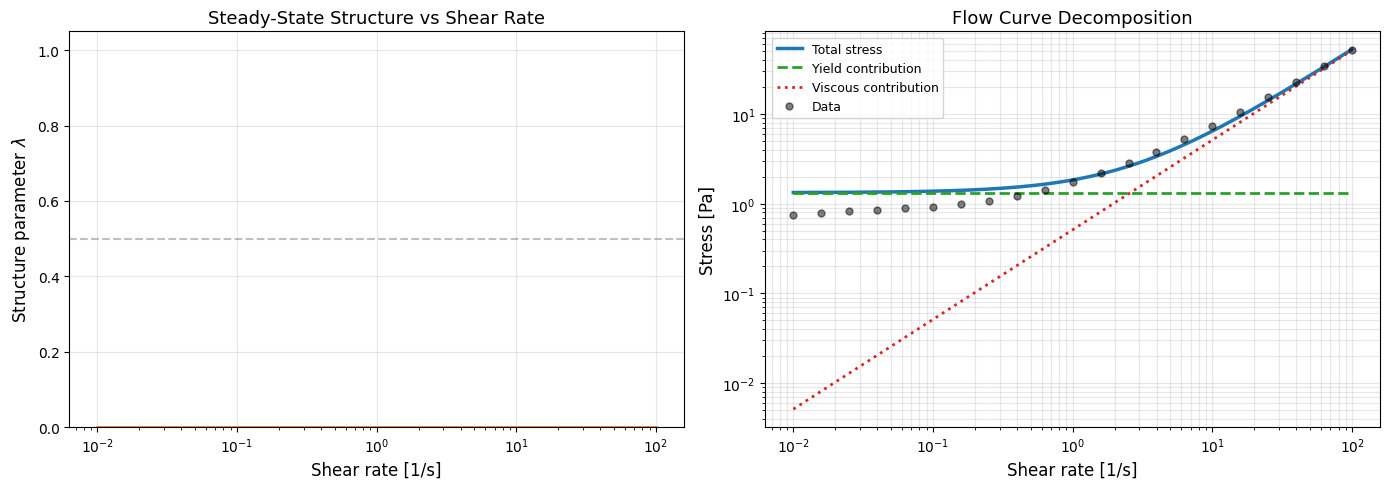

In [9]:
# Decompose flow curve into contributions
from ikh_tutorial_utils import compute_ikh_yield_stress, compute_thixotropic_structure

# Fine grid for smooth plotting
gamma_dot_fine = np.logspace(np.log10(gamma_dot.min()), np.log10(gamma_dot.max()), 200)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

# Steady-state structure at each shear rate
lambda_ss = compute_thixotropic_structure(gamma_dot_fine, tau_thix, Gamma)
sigma_y_ss = compute_ikh_yield_stress(lambda_ss, sigma_y0, delta_sigma_y)

# Viscous contribution
sigma_viscous = eta_inf * gamma_dot_fine

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Structure evolution
ax1.semilogx(gamma_dot_fine, lambda_ss, lw=2, color="C1")
ax1.set_xlabel("Shear rate [1/s]", fontsize=12)
ax1.set_ylabel("Structure parameter $\\lambda$", fontsize=12)
ax1.set_title("Steady-State Structure vs Shear Rate", fontsize=13)
ax1.set_ylim(0, 1.05)
ax1.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
ax1.grid(True, alpha=0.3)

# Right: Stress decomposition
ax2.loglog(gamma_dot_fine, stress_pred_fine, lw=2.5, color="C0", label="Total stress")
ax2.loglog(gamma_dot_fine, sigma_y_ss, "--", lw=2, color="C2", label="Yield contribution")
ax2.loglog(gamma_dot_fine, sigma_viscous, ":", lw=2, color="C3", label="Viscous contribution")
ax2.loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")

ax2.set_xlabel("Shear rate [1/s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Flow Curve Decomposition", fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling.

In [10]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:15s} = {val:.4g}")

# Fast demo config
# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G               = 1000
  eta             = 100.2
  C               = 1.376e+04
  gamma_dyn       = 1.621
  m               = 1.369
  sigma_y0        = 1.328
  delta_sigma_y   = 0.01783
  tau_thix        = 4.119e+07
  Gamma           = 3351
  eta_inf         = 0.513
  mu_p            = 0.001

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<02:29,  1.00s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  20%|██        | 30/150 [00:01<00:03, 36.98it/s, 255 steps of size 1.83e-03. acc. prob=0.80]

sample:  69%|██████▊   | 103/150 [00:01<00:00, 141.48it/s, 31 steps of size 1.99e-01. acc. prob=0.93]

sample: 100%|██████████| 150/150 [00:01<00:00, 121.45it/s, 31 steps of size 1.99e-01. acc. prob=0.93]


Bayesian inference time: 3.3 s


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 for production).

**Diagnostic Interpretation:**

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain convergence (1.0 = perfect) |
| **ESS (bulk)** | > 400 | Effective independent samples |
| **Divergences** | < 1% of samples | NUTS geometric issues |

**What to do if diagnostics fail:**
- R-hat > 1.01: Increase `num_warmup` or check initial values
- Low ESS: Run more samples or check for strong correlations
- Divergences: Increase `target_accept` (e.g., 0.95) or reparameterize

In [11]:
# Convergence diagnostics table
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0102       138      PASS
            eta    0.9929       126      PASS
              C    0.9954       218      PASS
      gamma_dyn    0.9909        85     CHECK
              m    1.0248        57     CHECK
       sigma_y0    1.0107        56     CHECK
  delta_sigma_y    1.0059        68     CHECK
       tau_thix    0.9923       191      PASS
          Gamma    0.9937        63     CHECK
        eta_inf    1.0022        86     CHECK
           mu_p    0.9936       151      PASS

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


### 5.3 ArviZ Diagnostic Plots

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


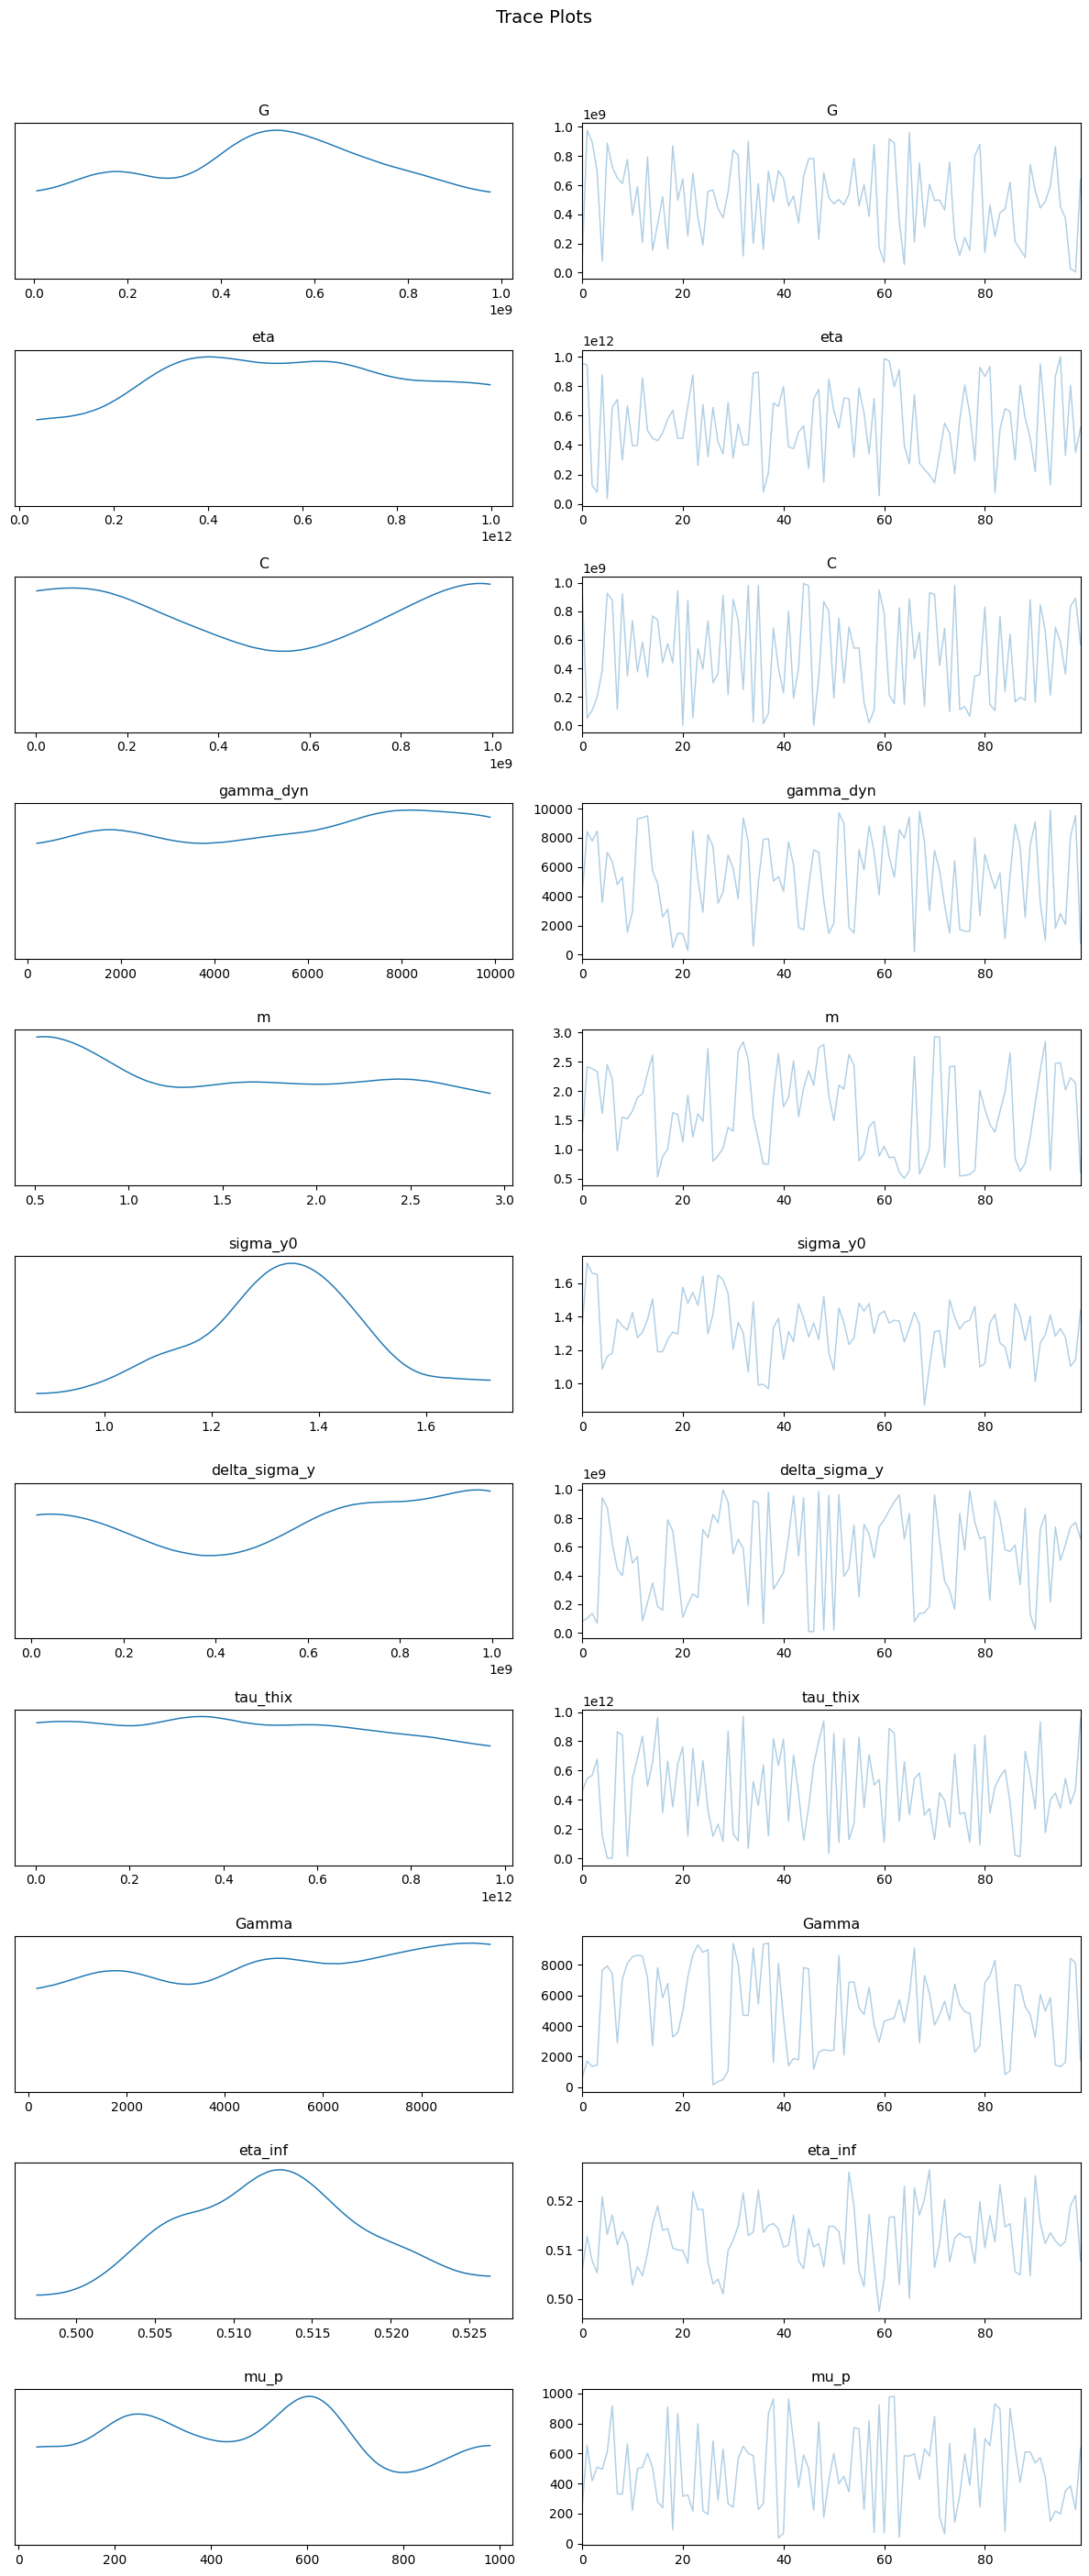

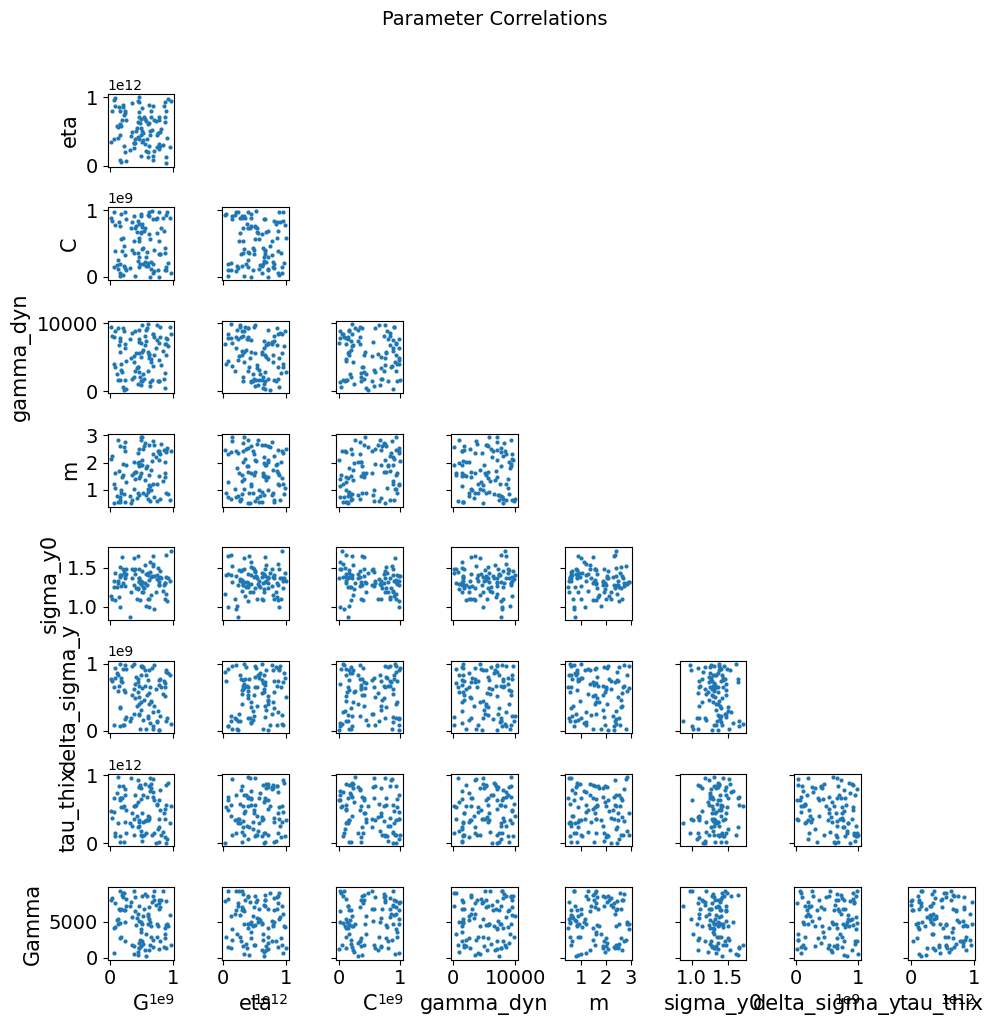

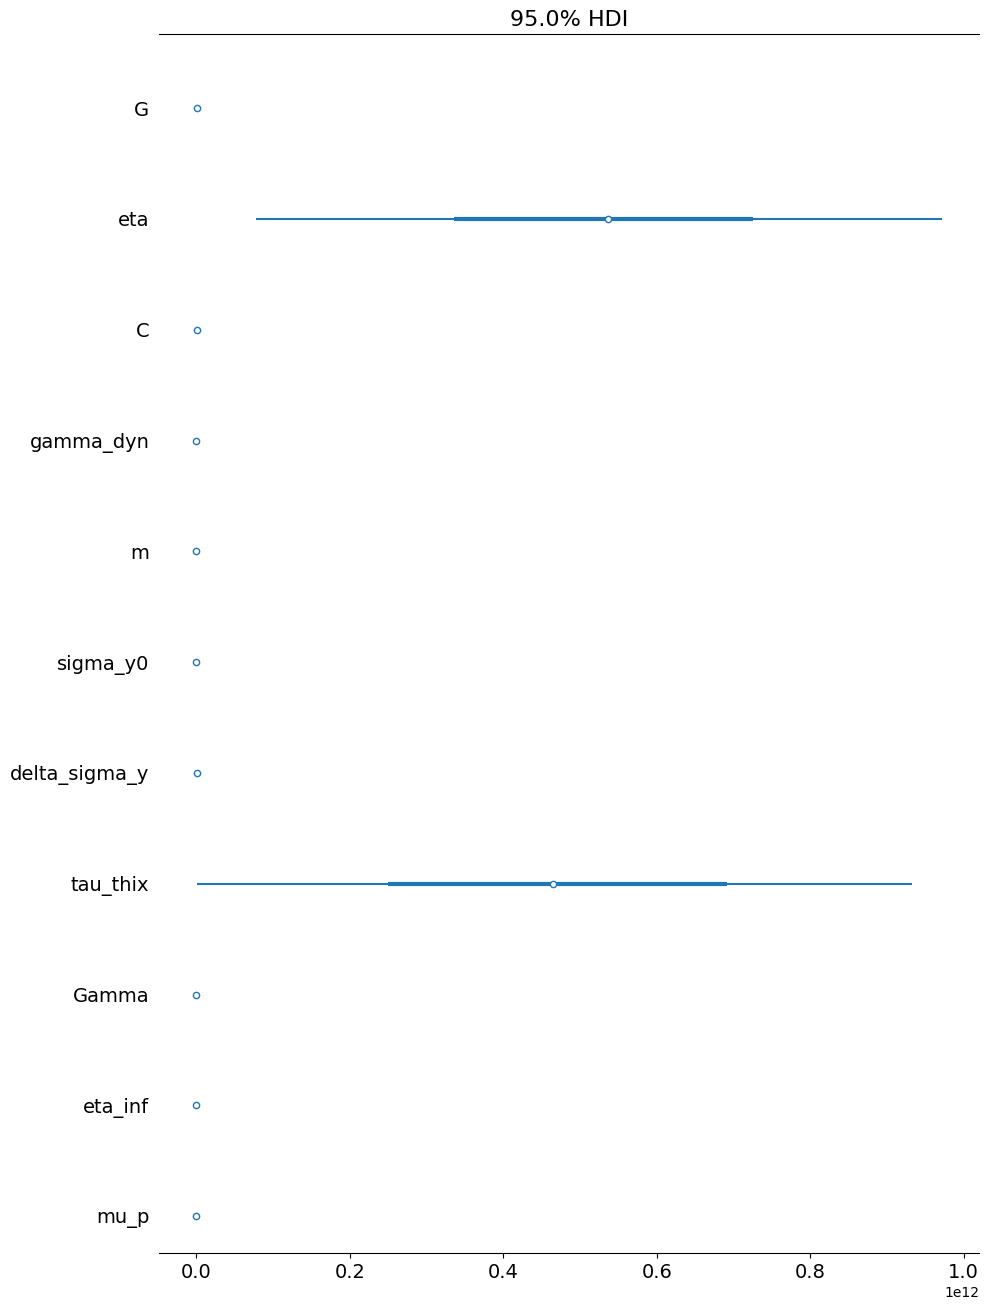

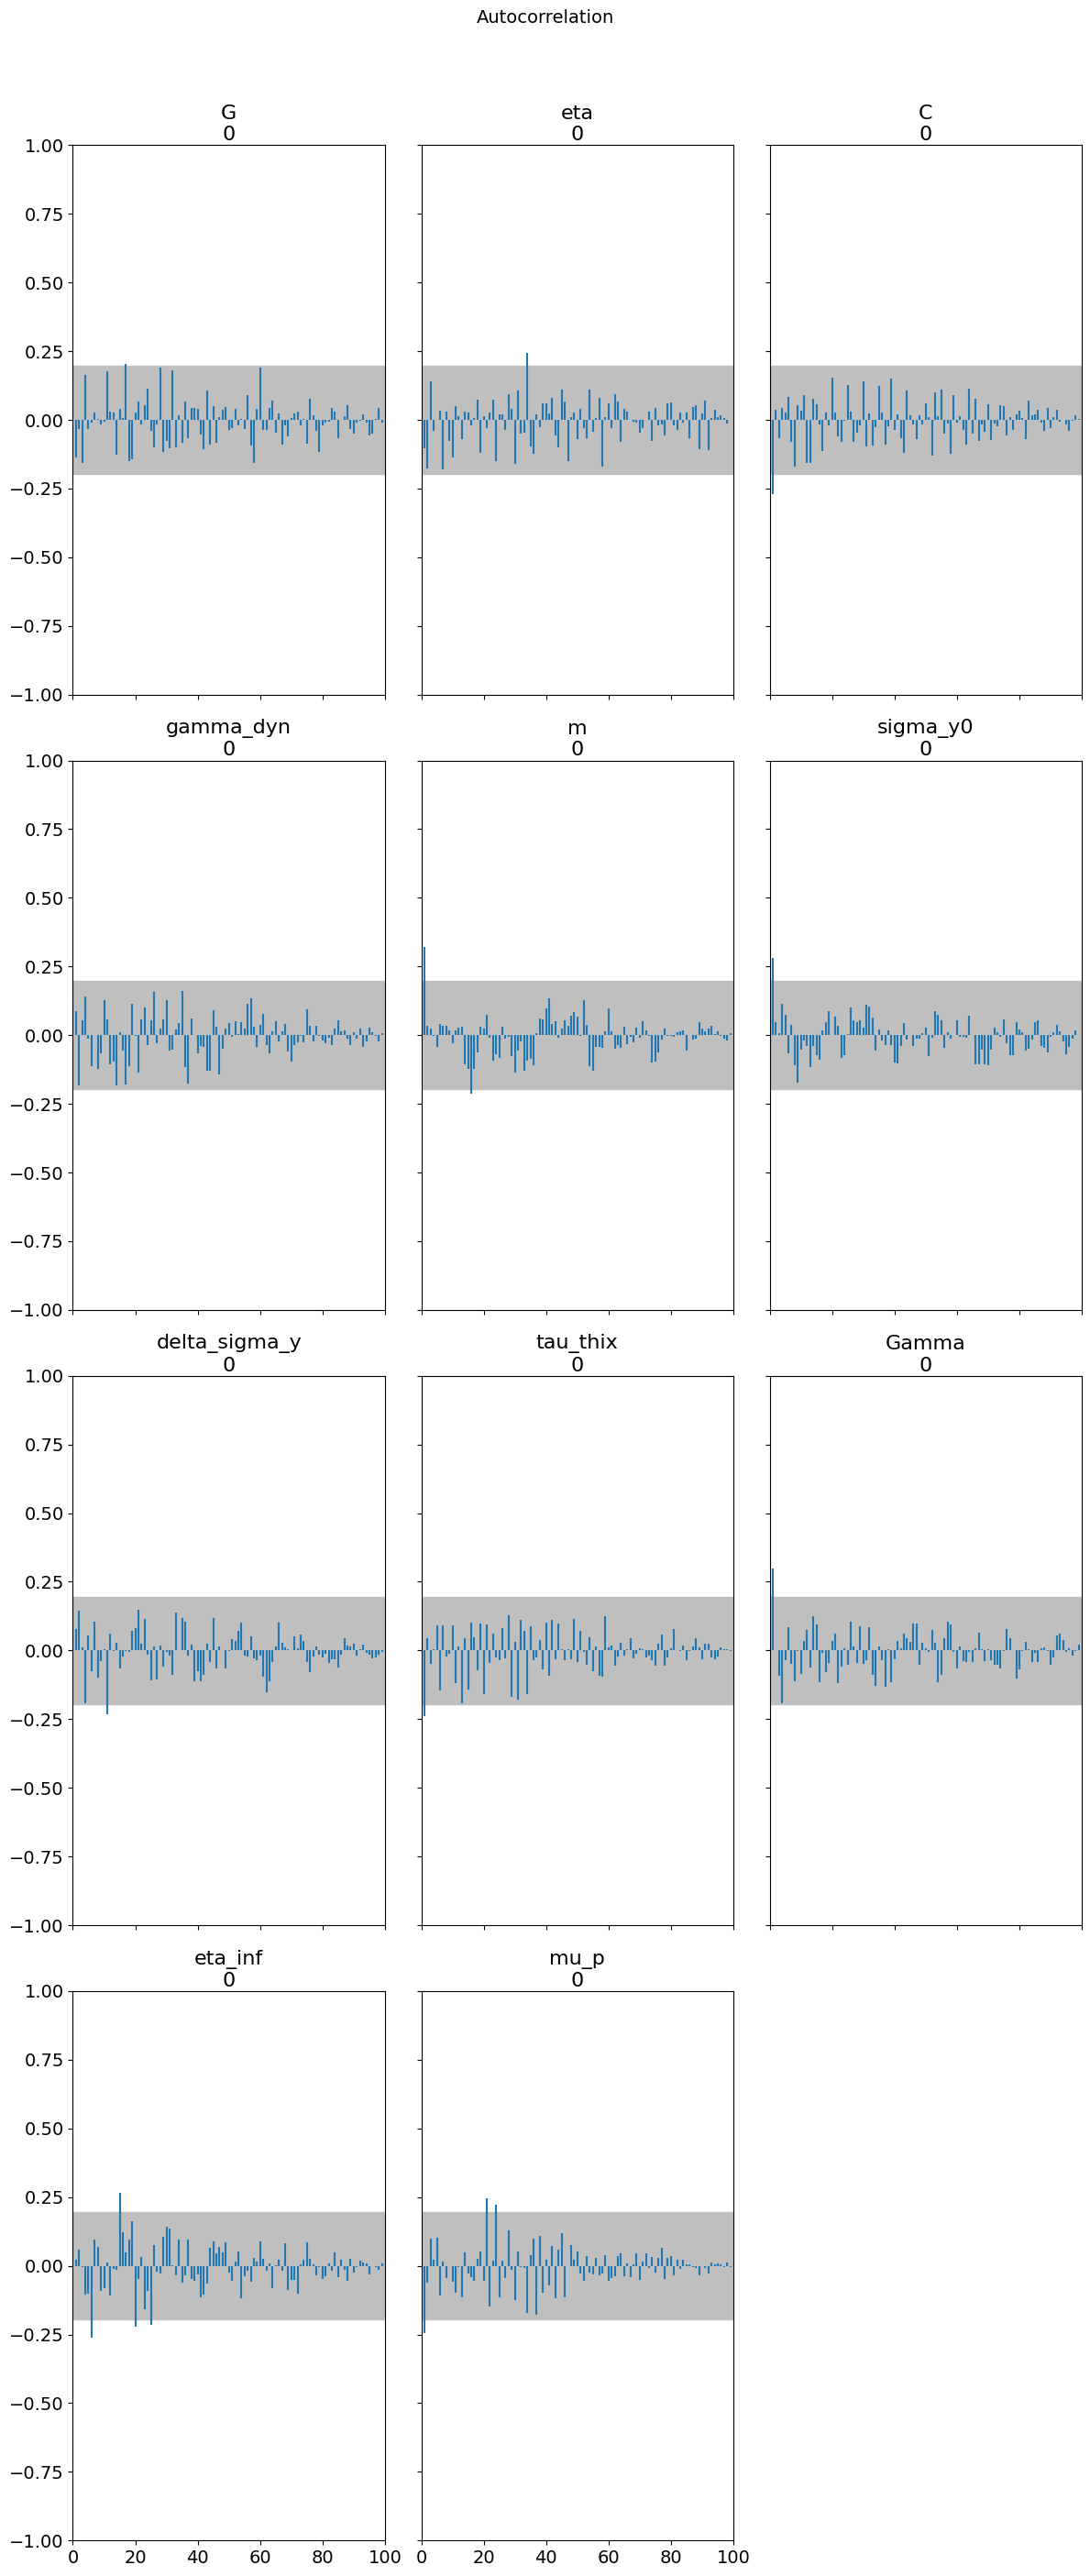

In [12]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

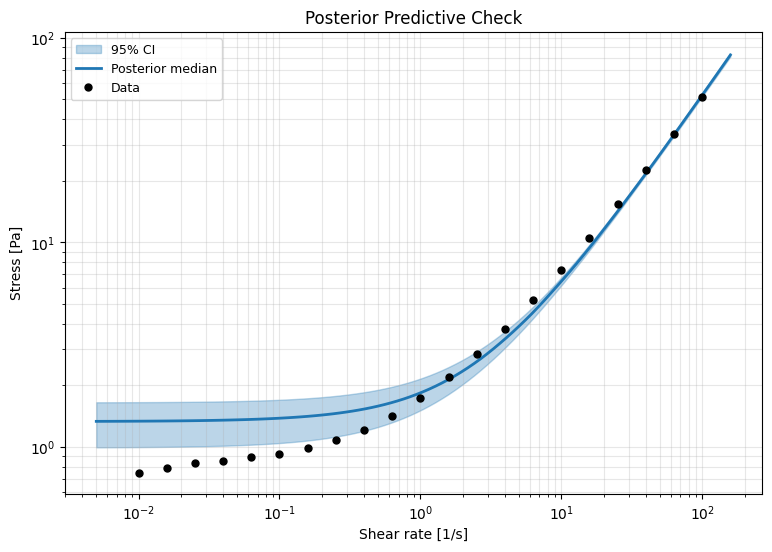

In [13]:
# Posterior predictive with 95% credible intervals
fig, ax = plot_posterior_predictive(
    gamma_dot, stress, model, result,
    test_mode="flow_curve", param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    log_scale=True,
)
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior medians and 95% credible intervals.

In [14]:
# NLSQ vs Bayesian comparison table
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G     6.406e+08     4.978e+08  [5.616e+07, 9.1e+08]
            eta     5.157e+11     5.364e+11  [7.881e+10, 9.641e+11]
              C     5.673e+08      4.39e+08  [1.563e+07, 9.817e+08]
      gamma_dyn         805.8          5405  [540.1, 9625]
              m        0.6097         1.613  [0.5539, 2.839]
       sigma_y0         1.441         1.333  [0.9944, 1.652]
  delta_sigma_y     6.586e+08     6.011e+08  [2.158e+07, 9.822e+08]
       tau_thix     9.577e+11     4.642e+11  [1.321e+10, 9.485e+11]
          Gamma          1776          4969  [569, 9315]
        eta_inf        0.5078        0.5126  [0.5017, 0.5242]
           mu_p         637.2           502  [66.85, 964.2]


## 6. Physical Interpretation

### Thixotropic Yield Stress

The MIKH model captures the essence of thixotropic yield-stress fluids:

- **At rest** ($\dot{\gamma} \to 0$): Structure builds up ($\lambda \to 1$), yield stress is maximum
- **Under flow**: Structure breaks down ($\lambda < 1$), yield stress decreases
- **Steady state**: Balance between rebuilding and breakdown determines $\lambda_{ss}$

### Flow Curve Regimes

1. **Low shear rates** ($\dot{\gamma} \ll \Gamma^{-1}$): 
   - Structure remains intact ($\lambda \approx 1$)
   - Stress approaches maximum yield stress $\sigma_{y0} + \Delta\sigma_y$

2. **Intermediate shear rates**:
   - Structure breakdown reduces yield stress
   - Shear-thinning behavior emerges

3. **High shear rates** ($\dot{\gamma} \gg \Gamma^{-1}$):
   - Structure fully destroyed ($\lambda \to 0$)
   - Stress dominated by $\sigma_{y0} + \eta_{\infty}\dot{\gamma}$

## 7. Save Results

Save parameters for use in synthetic data generation (NB03: Relaxation, NB05: SAOS).

In [15]:
# Save results for downstream notebooks
save_ikh_results(model, result, "mikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB03: Stress Relaxation")
print("  - NB05: SAOS")

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/flow_curve/
  nlsq_params_flow_curve.json: 11 parameters
  posterior_flow_curve.json: 100 draws

Parameters saved for synthetic data generation in:
  - NB03: Stress Relaxation
  - NB05: SAOS


## Key Takeaways

1. **MIKH model captures thixotropic flow curves** with structure-dependent yield stress:
   $\sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda$

2. **Structure evolution** balances aging (rebuilding) and flow-induced breakdown:
   $\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma\lambda|\dot{\gamma}^p|$

3. **11 parameters** control different physical mechanisms:
   - Elasticity: $G$, $\eta$
   - Kinematic hardening: $C$, $\gamma_{dyn}$, $m$
   - Yield/Thixotropy: $\sigma_{y0}$, $\Delta\sigma_y$, $\tau_{thix}$, $\Gamma$
   - Viscosity: $\eta_{\infty}$, $\mu_p$

4. **NLSQ warm-start is critical** for efficient Bayesian inference with 11 parameters

5. **Flow curve data alone** constrains yield and viscosity parameters well, but transient data (startup, relaxation) needed for kinematic hardening parameters

6. **Parameters calibrated here** will be used for synthetic relaxation (NB03) and SAOS (NB05) data generation

## Next Steps

- **NB02**: Startup shear (stress overshoot from structure breakdown + kinematic hardening)
- **NB03**: Stress relaxation (synthetic data from calibrated parameters)
- **NB04**: Creep response (delayed yielding)
- **NB05**: SAOS moduli (synthetic data from calibrated parameters)
- **NB06**: LAOS harmonics (nonlinear oscillatory response)

## Further Reading

**IKH Framework:**
- [IKH Family Overview](../../docs/source/models/ikh/index.rst) — Physical foundations, model hierarchy, when to use which model
- [MIKH Reference](../../docs/source/models/ikh/mikh.rst) — Complete governing equations, industrial applications, parameter estimation methods

**Key References:**
1. Dimitriou & McKinley (2014). "A comprehensive constitutive law for waxy crude oil: a thixotropic yield stress fluid." *Soft Matter*, 10, 6619-6644. https://doi.org/10.1039/c4sm00578c
2. Geri et al. (2017). "Thermokinematic memory and the thixotropic elasto‐viscoplasticity of waxy crude oils." *J. Rheol.*, 61(3), 427-454. https://doi.org/10.1122/1.4978259
3. Wei et al. (2018). "A multimode structural kinetics constitutive equation for the transient rheology of thixotropic elasto‐viscoplastic fluids." *J. Rheol.*, 62(1), 321-342. https://doi.org/10.1122/1.4996752

In [16]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc

try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
